In [25]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
from experiments.dataset import FinishedRun, Dataset

plt.style.use(["science", "resources/plt_custom.txt"])
api = wandb.Api(timeout=30)
entity = "joasiee"
DEFAULT_WIDTH = 485


def parse_run(run):
    return FinishedRun(
        run.name, run.config, pd.DataFrame.from_dict(run.scan_history())
    )

def get_runs_as_dataset(project, filters={}):
    runs = []
    for run in api.runs(entity + "/" + project, filters=filters):
        runs.append(parse_run(run))
    return Dataset(runs)

def set_size(width=DEFAULT_WIDTH, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [11]:
asgd_sampling = get_runs_as_dataset("sampling_experiment2", {"config.Optimizer": "AdaptiveStochasticGradientDescent", "config.SamplingPercentage": 0.1})

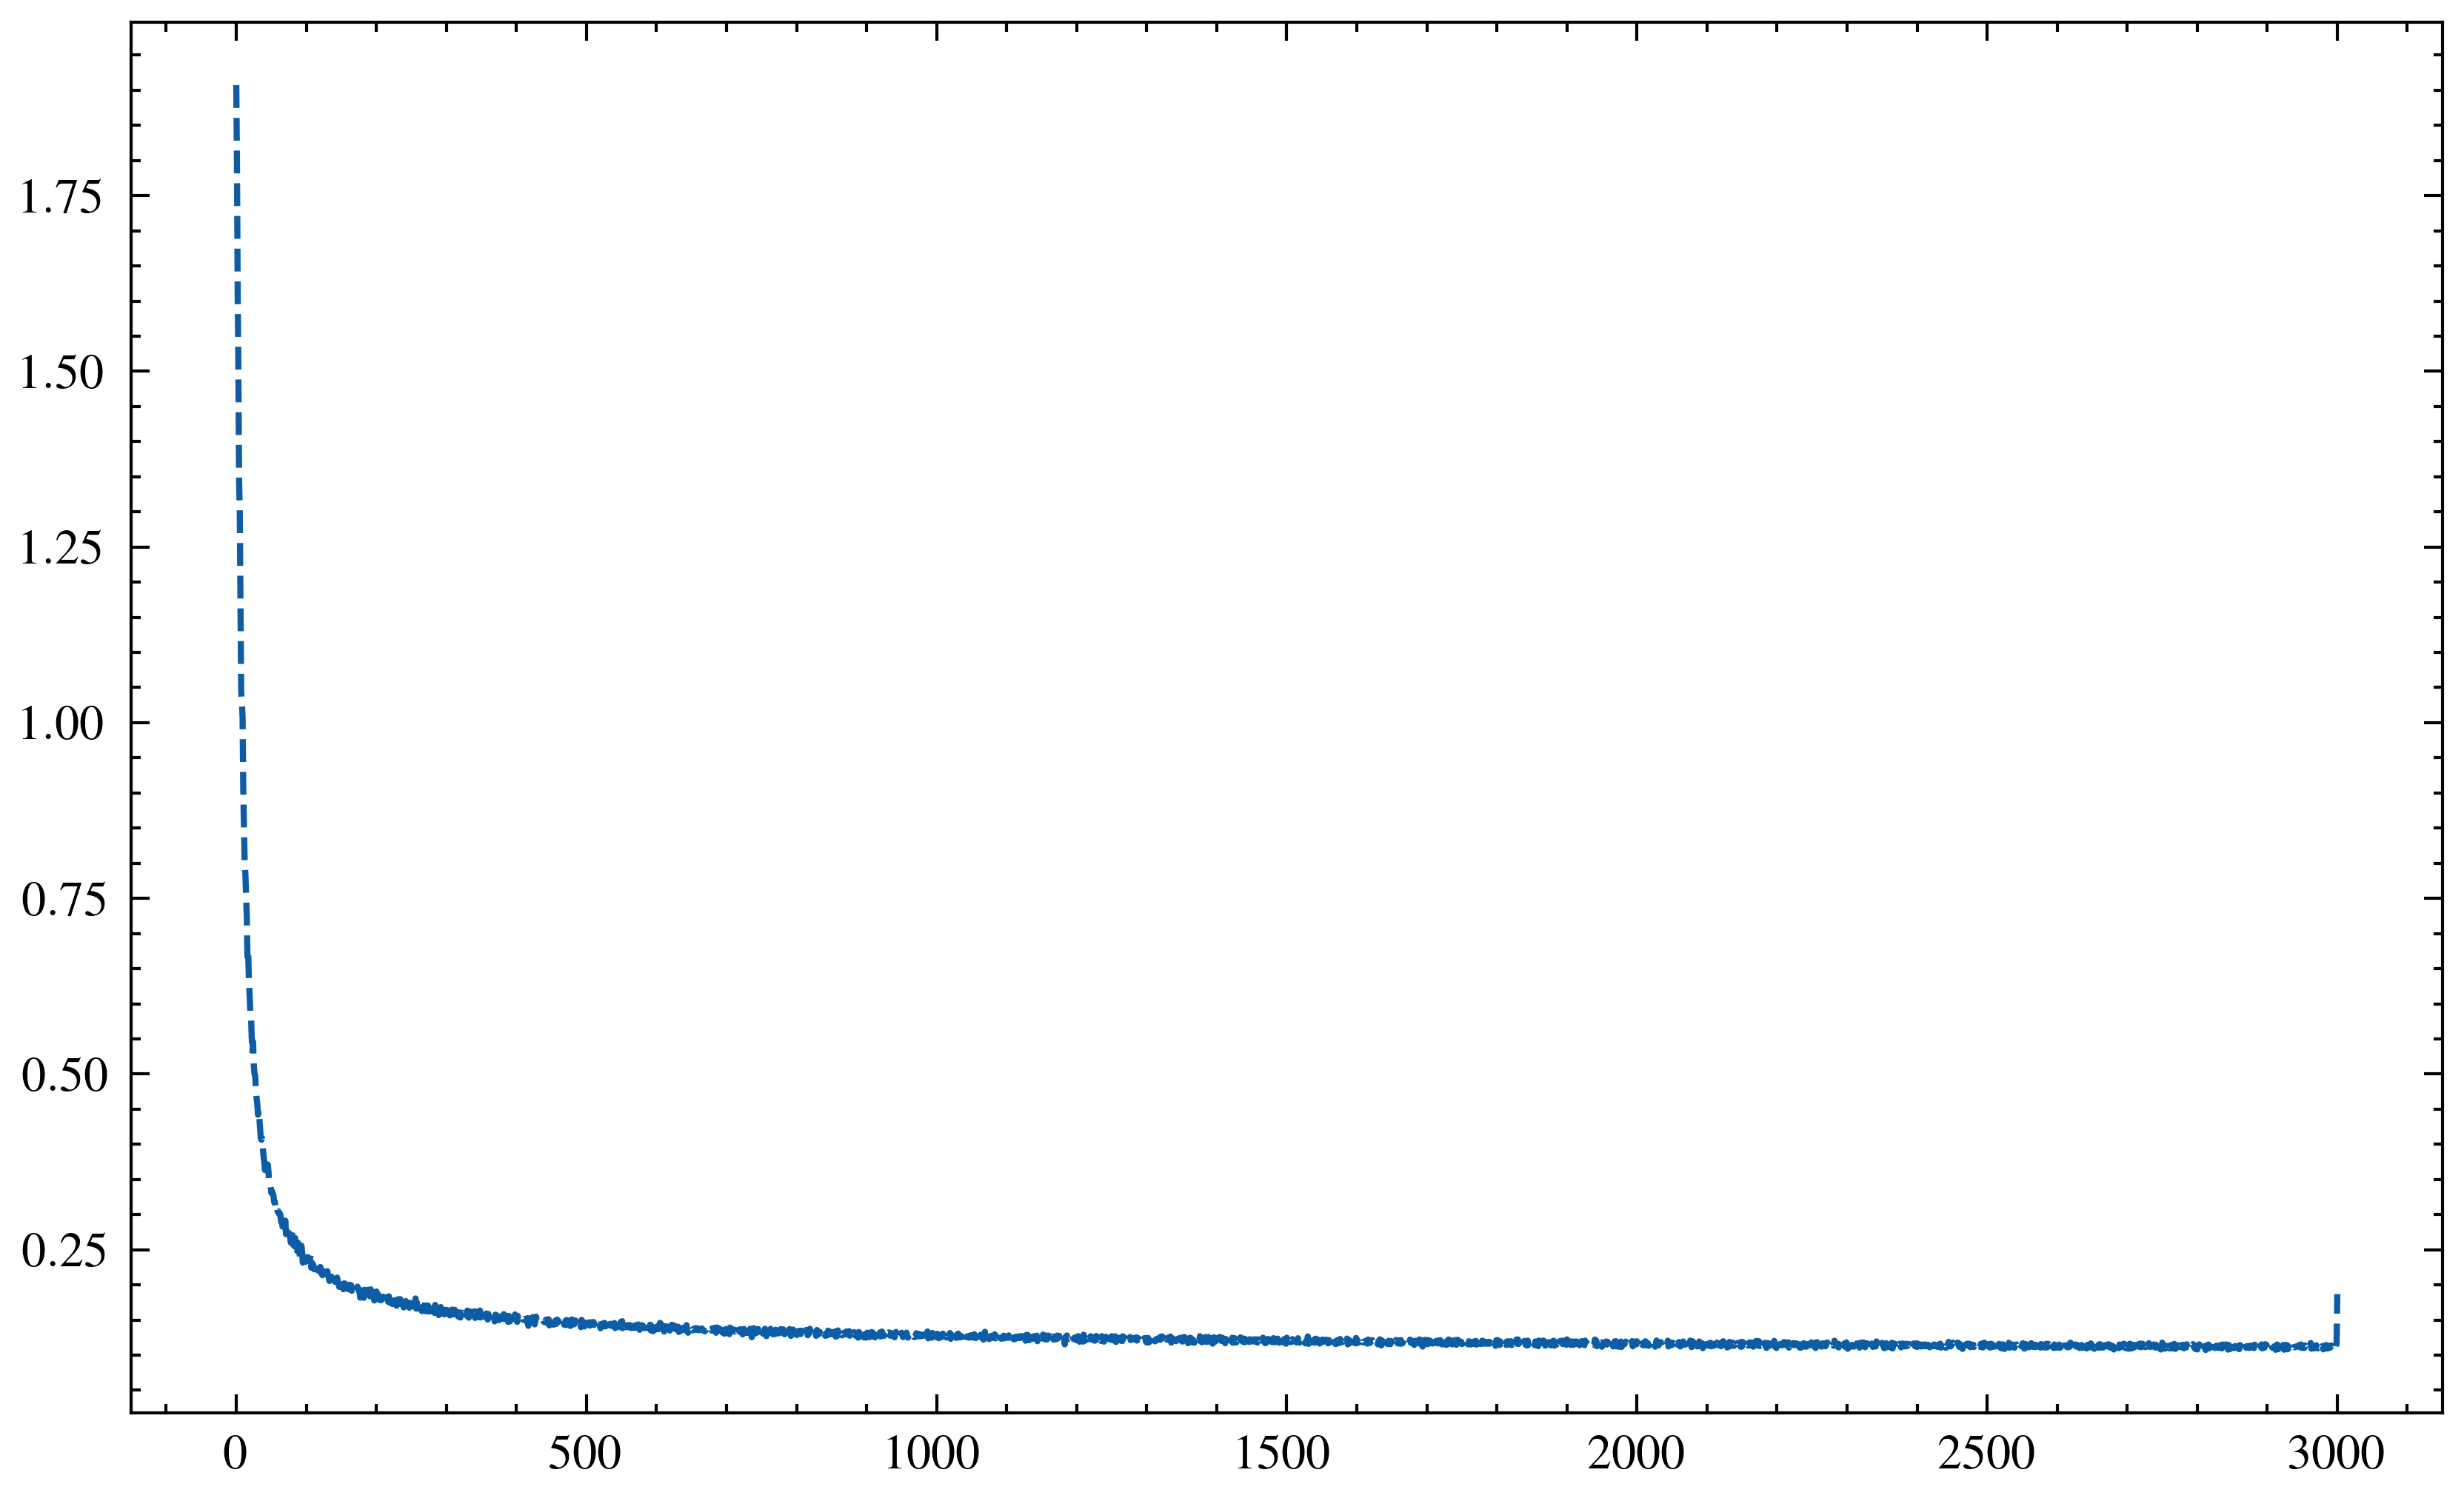

In [26]:
plt.plot(asgd_sampling.runs[0].resolutions_train[0]["R0/metric"].values)

In [23]:
set_size()

(6.710945067109451, 4.147592148107085)